In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn


In [2]:
transform = transforms.Compose(
    [transforms.ToTensor()])

batch_size = 50
root_dir = r'/Users/patrickpynadath/PycharmProjects/RobustnessResearch/OriginalWork'
trainset = torchvision.datasets.CIFAR10(root=root_dir, train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root=root_dir, train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [6]:
from base_classifier_arch import simple_conv_net 
net = simple_conv_net()

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
epochs = 100
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.207
[1,  4000] loss: 1.829
[1,  6000] loss: 1.650
[1,  8000] loss: 1.567
[1, 10000] loss: 1.477
[1, 12000] loss: 1.441
[2,  2000] loss: 1.381
[2,  4000] loss: 1.365
[2,  6000] loss: 1.325
[2,  8000] loss: 1.329
[2, 10000] loss: 1.295
[2, 12000] loss: 1.262
[3,  2000] loss: 1.211
[3,  4000] loss: 1.199
[3,  6000] loss: 1.195
[3,  8000] loss: 1.184
[3, 10000] loss: 1.175
[3, 12000] loss: 1.189
[4,  2000] loss: 1.083
[4,  4000] loss: 1.087
[4,  6000] loss: 1.115
[4,  8000] loss: 1.108
[4, 10000] loss: 1.086
[4, 12000] loss: 1.104
[5,  2000] loss: 1.007
[5,  4000] loss: 1.028
[5,  6000] loss: 1.022
[5,  8000] loss: 1.033
[5, 10000] loss: 1.038
[5, 12000] loss: 1.030
[6,  2000] loss: 0.935
[6,  4000] loss: 0.948
[6,  6000] loss: 0.974
[6,  8000] loss: 0.979
[6, 10000] loss: 0.993
[6, 12000] loss: 0.969
[7,  2000] loss: 0.873
[7,  4000] loss: 0.918
[7,  6000] loss: 0.931
[7,  8000] loss: 0.935
[7, 10000] loss: 0.919
[7, 12000] loss: 0.955
[8,  2000] loss: 0.850
[8,  4000] 

In [7]:
from vae_arch import VAE
from train_vae import train_model
import torch.optim as optim

vae = VAE(label="test", image_size=32, channel_num=3, kernel_num=50, z_size=50)
train_model(vae, trainloader, len(trainset), epochs=3)

epoch: 1 | iteration: 1000 | progress: [50000/50000] (100%) | loss => total: 2093.0330 / re: 2091.816 / kl: 1.217: : 1000it [00:40, 24.83it/s]



#############
# checkpoint!
#############





epoch: 2 | iteration: 2562 | progress: [50000/50000] (100%) | loss => total: 2092.9136 / re: 2091.417 / kl: 1.497: : 1000it [00:38, 25.97it/s]



#############
# checkpoint!
#############





epoch: 3 | iteration: 4124 | progress: [50000/50000] (100%) | loss => total: 2065.4065 / re: 2063.729 / kl: 1.678: : 1000it [00:40, 24.58it/s]



#############
# checkpoint!
#############




In [6]:
from math import ceil

import numpy as np
from scipy.stats import norm, binom_test
from statsmodels.stats.proportion import proportion_confint
import torch
from vae_arch import VAE


class Smooth(object):
    """A smoothed classifier g """

    # to abstain, Smooth returns this int
    ABSTAIN = -1

    def __init__(self, base_classifier: torch.nn.Module, num_classes: int, sigma: float):
        """
        :param base_classifier: maps from [batch x channel x height x width] to [batch x num_classes]
        :param num_classes:
        :param sigma: the noise level hyperparameter
        """
        self.base_classifier = base_classifier
        self.num_classes = num_classes
        self.sigma = sigma

    def certify(self, x: torch.tensor, n0: int, n: int, alpha: float, batch_size: int) -> (int, float):
        """ Monte Carlo algorithm for certifying that g's prediction around x is constant within some L2 radius.
        With probability at least 1 - alpha, the class returned by this method will equal g(x), and g's prediction will
        robust within a L2 ball of radius R around x.

        :param x: the input [channel x height x width]
        :param n0: the number of Monte Carlo samples to use for selection
        :param n: the number of Monte Carlo samples to use for estimation
        :param alpha: the failure probability
        :param batch_size: batch size to use when evaluating the base classifier
        :return: (predicted class, certified radius)
                 in the case of abstention, the class will be ABSTAIN and the radius 0.
        """
        self.base_classifier.eval()
        # draw samples of f(x+ epsilon)
        counts_selection = self._sample_noise(x, n0, batch_size)
        # use these samples to take a guess at the top class
        cAHat = counts_selection.argmax().item()
        # draw more samples of f(x + epsilon)
        counts_estimation = self._sample_noise(x, n, batch_size)
        # use these samples to estimate a lower bound on pA
        nA = counts_estimation[cAHat].item()
        pABar = self._lower_confidence_bound(nA, n, alpha)
        if pABar < 0.5:
            return Smooth.ABSTAIN, 0.0
        else:
            radius = self.sigma * norm.ppf(pABar)
            return cAHat, radius

    def predict(self, x: torch.tensor, n: int, alpha: float, batch_size: int) -> int:
        """ Monte Carlo algorithm for evaluating the prediction of g at x.  With probability at least 1 - alpha, the
        class returned by this method will equal g(x).

        This function uses the hypothesis test described in https://arxiv.org/abs/1610.03944
        for identifying the top category of a multinomial distribution.

        :param x: the input [channel x height x width]
        :param n: the number of Monte Carlo samples to use
        :param alpha: the failure probability
        :param batch_size: batch size to use when evaluating the base classifier
        :return: the predicted class, or ABSTAIN
        """
        self.base_classifier.eval()
        counts = self._sample_noise(x, n, batch_size)
        top2 = counts.argsort()[::-1][:2]
        count1 = counts[top2[0]]
        count2 = counts[top2[1]]
        if binom_test(count1, count1 + count2, p=0.5) > alpha:
            return Smooth.ABSTAIN
        else:
            return top2[0]

    def _sample_noise(self, x: torch.tensor, num: int, batch_size) -> np.ndarray:
        """ Sample the base classifier's prediction under noisy corruptions of the input x.

        :param x: the input [channel x width x height]
        :param num: number of samples to collect
        :param batch_size:
        :return: an ndarray[int] of length num_classes containing the per-class counts
        """
        with torch.no_grad():
            counts = np.zeros(self.num_classes, dtype=int)
            for _ in range(ceil(num / batch_size)):
                this_batch_size = min(batch_size, num)
                num -= this_batch_size

                batch = x.repeat((this_batch_size, 1, 1, 1))
                noise = torch.randn_like(batch) * self.sigma
                predictions = self.base_classifier(batch + noise).argmax(1)
                counts += self._count_arr(predictions.cpu().numpy(), self.num_classes)
            return counts

    def _count_arr(self, arr: np.ndarray, length: int) -> np.ndarray:
        counts = np.zeros(length, dtype=int)
        for idx in arr:
            counts[idx] += 1
        return counts

    def _lower_confidence_bound(self, NA: int, N: int, alpha: float) -> float:
        """ Returns a (1 - alpha) lower confidence bound on a bernoulli proportion.

        This function uses the Clopper-Pearson method.

        :param NA: the number of "successes"
        :param N: the number of total draws
        :param alpha: the confidence level
        :return: a lower bound on the binomial proportion which holds true w.p at least (1 - alpha) over the samples
        """
        return proportion_confint(NA, N, alpha=2 * alpha, method="beta")[0]


class SmoothVAE(Smooth):
    ABSTAIN = -1

    def __init__(self, base_classifier: torch.nn.Module, num_classes: int, sigma: float, trained_VAE: VAE):
        super().__init__(base_classifier, num_classes, sigma)
        # needs to be trained on the same set as the base classifier
        self.trained_VAE = trained_VAE

    def _sample_noise_vae(self, x: torch.tensor, num: int, batch_size) -> np.ndarray:
        # getting the representation of x within the latent space

        encoded = self.trained_VAE.encoder(x[None, :])
        z_mean, z_logvar = self.trained_VAE.q(encoded)
        z_proj = self.trained_VAE.project(z_mean)
        with torch.no_grad():
            counts = np.zeros(self.num_classes, dtype=int)
            for _ in range(ceil(num / batch_size)):
                this_batch_size = min(batch_size, num)
                num -= this_batch_size

                batch = z_proj.repeat((this_batch_size, 1, 1, 1))
                noise = torch.randn_like(batch) * self.sigma
                predictions = self.base_classifier(self.trained_VAE.decoder(batch + noise)).argmax(1)
                counts += self._count_arr(predictions.cpu().numpy(), self.num_classes)
            return counts
    
    def predict(self, x: torch.tensor, n: int, alpha: float, batch_size: int) -> int:
        """ Monte Carlo algorithm for evaluating the prediction of g at x.  With probability at least 1 - alpha, the
        class returned by this method will equal g(x).

        This function uses the hypothesis test described in https://arxiv.org/abs/1610.03944
        for identifying the top category of a multinomial distribution.

        :param x: the input [channel x height x width]
        :param n: the number of Monte Carlo samples to use
        :param alpha: the failure probability
        :param batch_size: batch size to use when evaluating the base classifier
        :return: the predicted class, or ABSTAIN
        """
        self.base_classifier.eval()
        counts = self._sample_noise_vae(x, n, batch_size)
        top2 = counts.argsort()[::-1][:2]
        count1 = counts[top2[0]]
        count2 = counts[top2[1]]
        if binom_test(count1, count1 + count2, p=0.5) > alpha:
            return Smooth.ABSTAIN
        else:
            return top2[0]

In [9]:
from certification import certify_classifier
# need to generate the certification results for varying sigma
sigmas = [.12, .25, .5, 1]

# setting the parameters for the certification algorithm 
num_classes = len(classes)
skip_examples = 20
max_examples = 1000
alpha = .05
n0 = 100
n=1000
batch = 1
base_file_name = "cert_results_sigma_vae"
for s in sigmas:
    print(f"""Certifying Smooth Classifier with sigma = {s}""")
    out_file_name = base_file_name + str(s)
    certify_classifier(net, testset, num_classes, out_file_name, skip_examples, max_examples, s, alpha, batch, n0, n, use_vae = False, trained_vae = None)

Certifying Smooth Classifier with sigma = 0.12
Certifying Smooth Classifier with sigma = 0.25
Certifying Smooth Classifier with sigma = 0.5
Certifying Smooth Classifier with sigma = 1


In [10]:
from generate_github_result import generate_accuracy_vs_radii_graph
generate_accuracy_vs_radii_graph(base_file_name, sigmas, "baseline_smoothing")

In [9]:
# need to visualize peturbatins in sample space translated to latent 
# sample randomly n samples 



# get latent representations for each x 

# peturb x by random samples 
# put through encoder 
# compare result of the encoded peturbations to the original latent representation 

# NO NEED TO PETURB THE LATENT INPUTS 
# put through decoder 
# compare to the original sample 

In [8]:
# working in numpy bc better compatability with matplot 
import numpy as np 
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 100
root_dir = r'/Users/patrickpynadath/PycharmProjects/RobustnessResearch/OriginalWork'
trainset = torchvision.datasets.CIFAR10(root=root_dir, train=True,
                                        download=False, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root=root_dir, train=False,
                                       download=False, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
cur_batch = next(iter(trainloader))

In [9]:
# num samples refers to the number of samples used to estimate the latent representation
def latent_peturbation_analysis(x, trained_vae):
    def get_z(x): 
        encoded = trained_vae.encoder(torch.tensor(x[None, :]).float())
        mean, logvar = trained_vae.q(encoded)
        z_proj = trained_vae.project(mean).view(-1, trained_vae.kernel_num,
                                        trained_vae.feature_size,
                                        trained_vae.feature_size,)
        return z_proj.detach().numpy()

    delta = np.random.normal(size=x.shape)
    z = get_z(x)
    peturb_z = get_z(x + delta) 
    latent_delta = np.random.normal(size = z.shape)
    peturb_x = trained_vae.decoder(torch.tensor(z + latent_delta).float()).detach().numpy() 
    return x, z, peturb_x, peturb_z

In [13]:
samples = cur_batch[0].numpy()
labels = cur_batch[1].numpy()
latent_differences = []
sample_space_differences = []
for i in range(batch_size):
    x = samples[i, :]
    x, z, peturb_x, peturb_z = latent_peturbation_analysis(x, vae)
    print(i)
    print(f"Norm of latent representation (l2): {np.linalg.norm(z)}")
    print(f"Norm of latent representation (linfty): {np.amax(z)}")
    latent_differences.append(np.amax(np.abs(peturb_z - z)))
    sample_space_differences.append(np.amax(np.abs(peturb_x - x)))
    
    
# need to figure out why this doesn't look like a Gaussian 

0
Norm of latent representation (l2): 15.456676483154297
Norm of latent representation (linfty): 2.004953622817993
1
Norm of latent representation (l2): 9.844366073608398
Norm of latent representation (linfty): 1.447946548461914
2
Norm of latent representation (l2): 15.00534439086914
Norm of latent representation (linfty): 1.534693956375122
3
Norm of latent representation (l2): 27.785247802734375
Norm of latent representation (linfty): 5.722641468048096
4
Norm of latent representation (l2): 16.67546844482422
Norm of latent representation (linfty): 2.2640867233276367
5
Norm of latent representation (l2): 15.137807846069336
Norm of latent representation (linfty): 1.6010128259658813
6
Norm of latent representation (l2): 16.803791046142578
Norm of latent representation (linfty): 2.725893974304199
7
Norm of latent representation (l2): 13.77648639678955
Norm of latent representation (linfty): 1.6172987222671509
8
Norm of latent representation (l2): 17.5495662689209
Norm of latent representat

82
Norm of latent representation (l2): 16.565305709838867
Norm of latent representation (linfty): 1.8230094909667969
83
Norm of latent representation (l2): 13.94734001159668
Norm of latent representation (linfty): 1.7195470333099365
84
Norm of latent representation (l2): 14.244993209838867
Norm of latent representation (linfty): 1.6998398303985596
85
Norm of latent representation (l2): 11.947233200073242
Norm of latent representation (linfty): 1.3817152976989746
86
Norm of latent representation (l2): 16.665084838867188
Norm of latent representation (linfty): 1.9641356468200684
87
Norm of latent representation (l2): 15.036710739135742
Norm of latent representation (linfty): 1.5122132301330566
88
Norm of latent representation (l2): 15.85049057006836
Norm of latent representation (linfty): 1.8467280864715576
89
Norm of latent representation (l2): 21.591073989868164
Norm of latent representation (linfty): 2.64507794380188
90
Norm of latent representation (l2): 17.82673454284668
Norm of lat

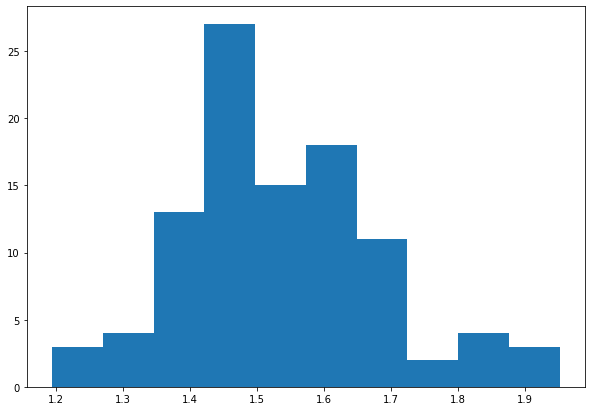

In [11]:
# these are differences between the original sample, and the corruption obtained by peturbing the latent representation
# and feeding this to the decoder 

from matplotlib import pyplot as plt

x_differences = np.array(sample_space_differences)
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(x_differences)
plt.show()

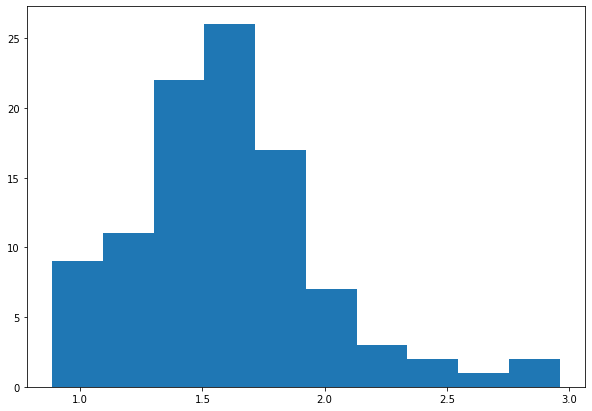

In [12]:
z_differences = np.array(latent_differences)
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(z_differences)
plt.show()

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [118]:
peturb_z.shape

(1, 4, 4, 4)

In [35]:
samples[0].min()

-1.0